# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

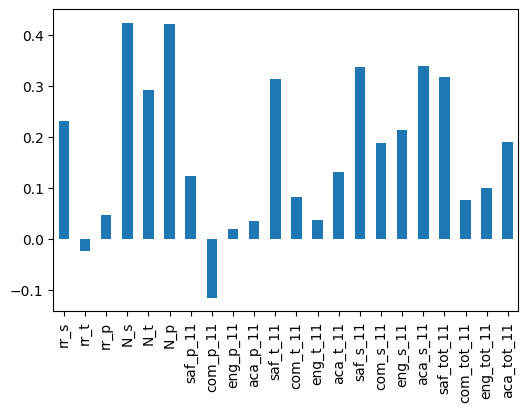

In [19]:
survey_corr=combined.corr()['sat_score'].loc[survey_fields]
# only correlation sat_score with survey data
survey_corr.plot(kind='bar')

saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school. Look deeply

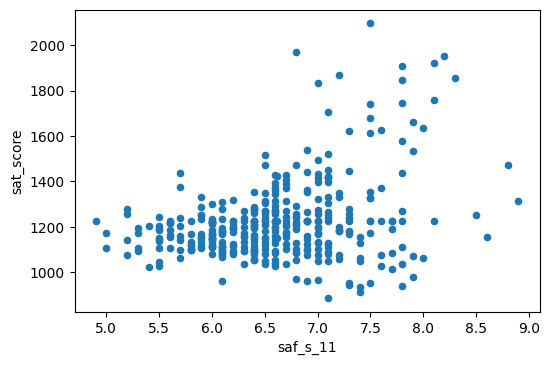

In [20]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

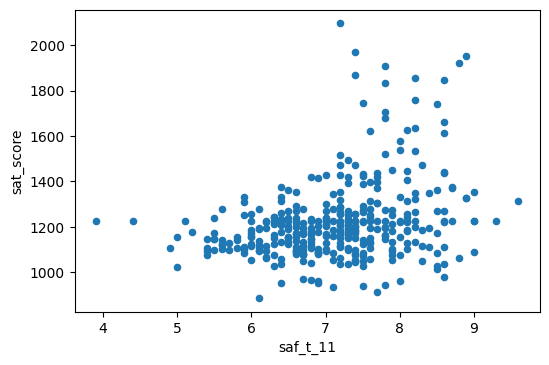

In [21]:
combined.plot(kind='scatter', x='saf_t_11', y='sat_score')

We can see positive correlation safety with sat_score

In [23]:
race=['white_per','asian_per','black_per','hispanic_per']

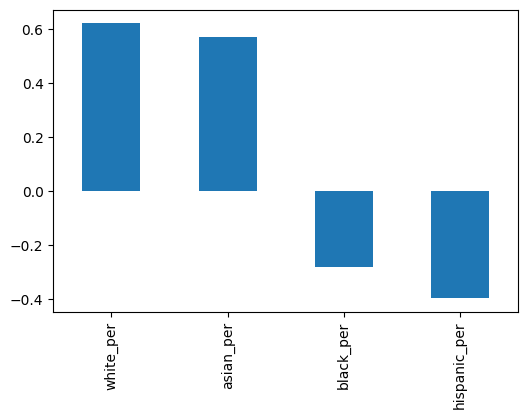

In [24]:
race_corr=combined.corr()['sat_score'][race] #learn correlation with race
race_corr.plot(kind='bar')

hispanic have a low sat_score with hight hispanic_per

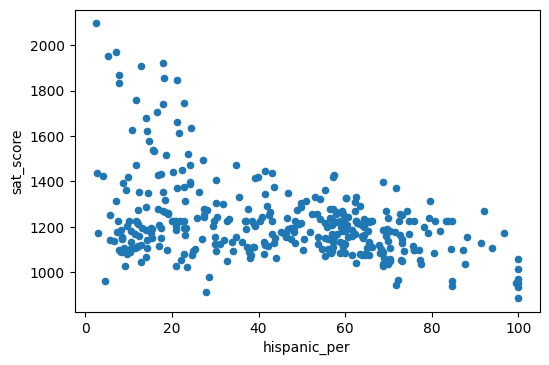

In [25]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')

In [31]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [33]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

first list are almost schools for immigrants low-income (mostly) spanish family
second - high level education school

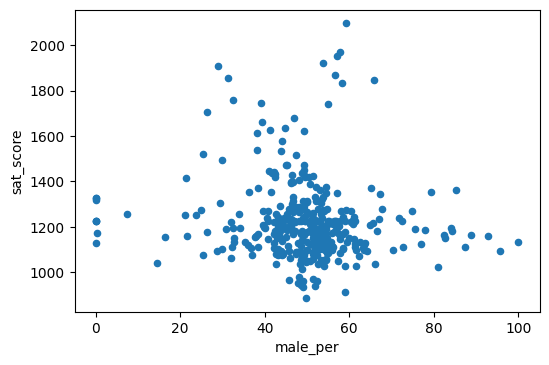

In [34]:
combined.plot(kind='scatter', x='male_per', y='sat_score')

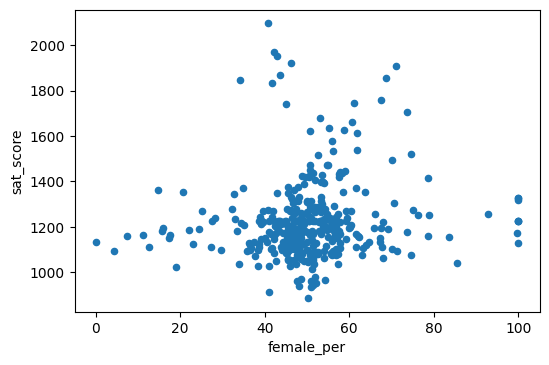

In [35]:
combined.plot(kind='scatter', x='female_per', y='sat_score')

In [39]:
combined[(combined['female_per']>60)&(combined['sat_score']<1700)]['SCHOOL NAME']

9                  HIGH SCHOOL OF HOSPITALITY MANAGEMENT
14                          LOWER MANHATTAN ARTS ACADEMY
15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
16                             GRAMERCY ARTS HIGH SCHOOL
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
29     HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...
34                             MANHATTAN VILLAGE ACADEMY
40                          TALENT UNLIMITED HIGH SCHOOL
43        REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS
45                                NEW DESIGN HIGH SCHOOL
48              RICHARD R. GREEN HIGH SCHOOL OF TEACHING
49                 THE HIGH SCHOOL OF FASHION INDUSTRIES
58     WADLEIGH SECONDARY SCHOOL FOR THE PERFORMING &...
69                         CENTRAL PARK EAST HIGH SCHOOL
70                       YOUNG WOMEN'S LEADERSHIP SCHOOL
71                       YOUNG WOMEN'S LEADERSHIP SCHOOL
76         URBAN ASSEMBLY SCHOO

In [41]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

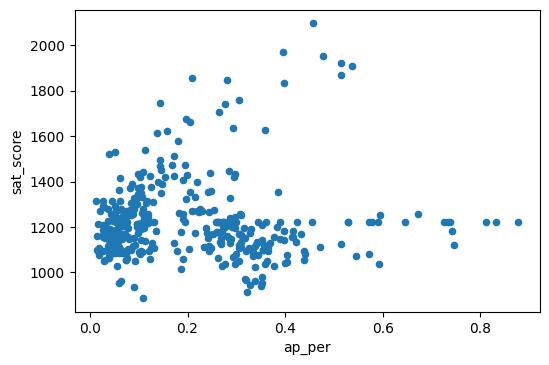

In [42]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores.

In [ ]:
combined.plot(ki)